In [21]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as ss
import pingouin as pg


sns.set(rc={'figure.figsize':(10,5)}, palette='colorblind', style="whitegrid")

In [22]:
cookie_cats = pd.read_csv('cookie_cats.csv')
cookie_cats.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Описание данных

- userid - ID игрока.
- version - группа, в которую был помещен игрок случайным образом:
    - gate_30 (контрольная группа) - группа игроков, помещенная в зону 30 уровня;
    - gate_40 (тестовая группа) - группа игроков, помещенная в зону 40 уровня.
- sum_gamerounds - количество уровней, которое прошел игрок в период A/B теста.
- retention_1 - вернулся ли игрок на следующий день после установки игры.
- retention_7 - вернулся ли игрок на 7 после установки игры.

### EDA

In [23]:
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [24]:
cookie_cats.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [25]:
cookie_cats.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [26]:
cookie_cats.groupby('version').userid.count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

In [27]:
cookie_cats.groupby('version').sum_gamerounds.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Всего 90189 вхождений. ID игроков уникальны. Типы данных соответствуют заявленным.

- В контрольной группе (30 ур.) - 44700 игрока.
- В тестовой группе (40 ур.) - 45489 игроков.
Распределение групп примерно равное.

Посмотрим на распределение количества пройденных игроками уровней по группам.

In [28]:
game_round_count = cookie_cats.groupby(['version', 'sum_gamerounds'], as_index=False).userid.count().rename(columns={'userid':'user_count'})
game_round_count

,version,sum_gamerounds,user_count
0,gate_30,0,1937
1,gate_30,1,2749
2,gate_30,2,2198
3,gate_30,3,1899
4,gate_30,4,1831
...,...,...,...
1566,gate_40,2015,1
1567,gate_40,2063,1
1568,gate_40,2124,1
1569,gate_40,2294,1


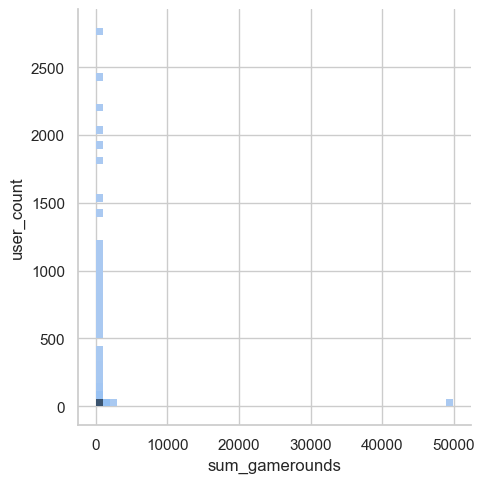

In [29]:
sns.displot(data=game_round_count, x='sum_gamerounds', y='user_count', bins=50)
plt.show()

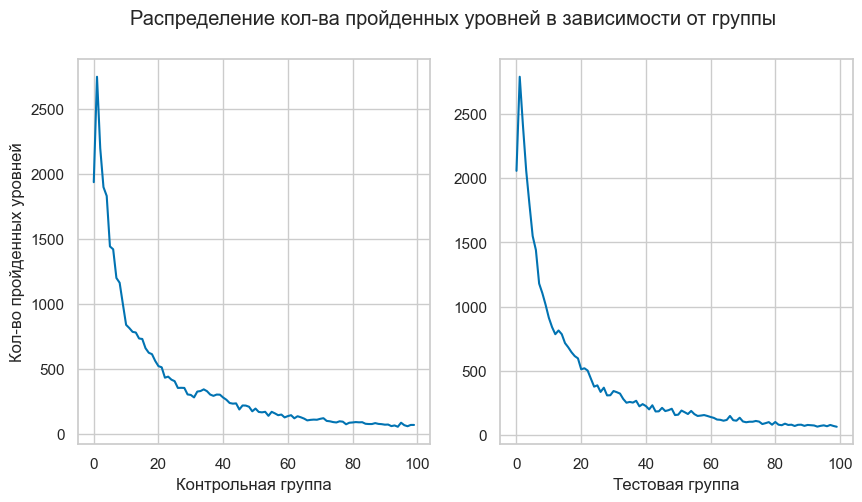

In [30]:
# т.к кол-во сыграных уровней сильно перекошено, то ограничим выборку 100 уровнями.
plt.subplot(1, 2, 1)
sns.lineplot(data=game_round_count.query('version=="gate_30"').head(100), 
             x='sum_gamerounds', 
             y='user_count'
             )
plt.ylabel('Кол-во пройденных уровней')
plt.xlabel('Контрольная группа')

plt.subplot(1, 2, 2)
sns.lineplot(data=game_round_count.query('version=="gate_40"').head(100), 
             x='sum_gamerounds', 
             y='user_count'
             )
plt.ylabel('')
plt.xlabel('Тестовая группа')
plt.suptitle('Распределение кол-ва пройденных уровней в зависимости от группы')
plt.show()

Распределение количество пройденных уровней в обоих группах схоже. И в контрольной, и в тестовой группе видно, что большая часть игроков сыграла максимум пару раз.

Посмотрим на игроков, которые не  сыграли ни разу для каждой группы.

In [31]:
cookie_cats.query('sum_gamerounds==0').groupby('version').userid.count()

version
gate_30    1937
gate_40    2057
Name: userid, dtype: int64

Не сыграли ни разу:
- В контрольной группе: 1937 человек.
- В тестовой группе 2057 человек.  

Нам не столько важно, сколько человек не начали играть. Более важно то, какой процент человек вернулся после установки игры: retention n-ого дня. В данном случает у нас есть данные о 1 и седьмом днях.

Но перед тем как изучить эти метрики, посмотрим на другие.

### Метрика 1:
Медианное кол-во сыгранных уровней.

H0: Медианное кол-во сыгранных уровней в группах **не различается**.

H1: Медианное кол-во сыгранных уровней в группах **различается**.

In [32]:
median = cookie_cats.groupby('version', as_index=False).agg({'sum_gamerounds':'median'}).round(2)
median

,version,sum_gamerounds
0,gate_30,17.0
1,gate_40,16.0


Для оценки медианы используем bootstrap.

In [33]:
median = []

for i in range(1000):
    sample_median = cookie_cats.sample(frac=1, replace=True).groupby('version').sum_gamerounds.median()
    median.append(sample_median)
    
median = pd.DataFrame(median)

In [34]:
median.head()

version,gate_30,gate_40
sum_gamerounds,17.0,16.0
sum_gamerounds,17.0,16.0
sum_gamerounds,17.0,16.0
sum_gamerounds,17.0,16.0
sum_gamerounds,17.0,16.0


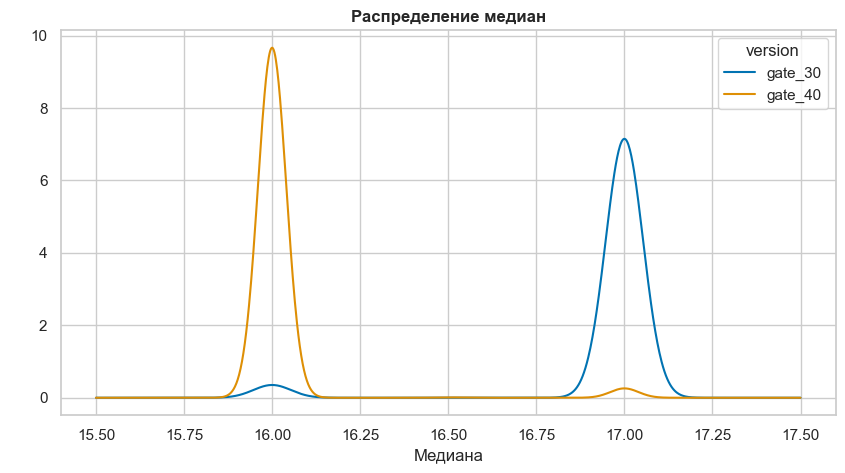

In [35]:
median.plot.kde()
plt.xlabel("Медиана")
plt.ylabel(" ")
plt.title("Распределение медиан", fontweight="bold")

plt.show()

In [36]:
median['diff'] = median.gate_30 - median.gate_40
print(median['diff'].quantile(0.975))
print(median['diff'].quantile(0.025))

1.0
0.0


Доверительные интервалы перекрываются, что значит, что различия между двумя группами статистически незначимы, поэтому мы не отклоняем H0.

### Метрика 2:
Среднее кол-во сыгранных уровней.

H0: Среднее кол-во сыгранных уровней в группах **не различается**.

H1: Среднее кол-во сыгранных уровней в группах **различается**.

In [37]:
cookie_cats.groupby('version', as_index=False).sum_gamerounds.mean().round(2)

,version,sum_gamerounds
0,gate_30,52.46
1,gate_40,51.30


В первую очередь необходимо проверить данные на нормальность и на различия в дисперсиях.

In [38]:
pg.homoscedasticity(data=cookie_cats, dv='sum_gamerounds', group='version')

,W,pval,equal_var
levene,0.5292,0.466945,True


Дисперсии по группам равны.

In [39]:
mean_30 = cookie_cats.query('version=="gate_30"').sum_gamerounds
mean_40 = cookie_cats.query('version=="gate_40"').sum_gamerounds

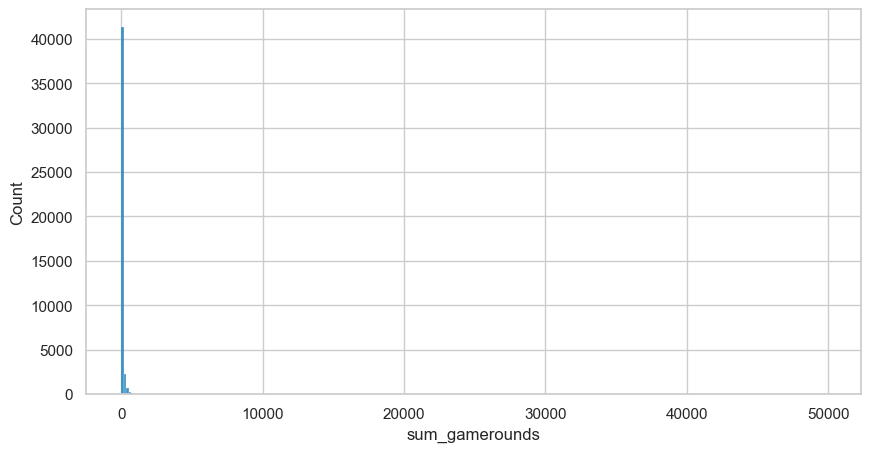

In [40]:
sns.histplot(mean_30, bins=300)
plt.show()

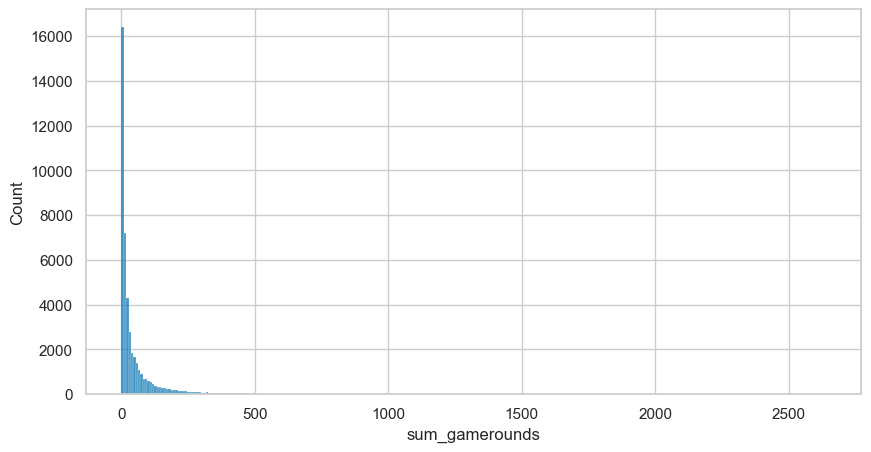

In [41]:
sns.histplot(mean_40, bins=300)
plt.show()

Дисперсии гомогенны, распределение ненормально. Из-за достаточного размера выборки можно использовать Т-тест Стьюдента. Также можно использовать тест Колмагорова-Смирнова. Остановимся на втором.

In [42]:
stat, p = ss.ks_2samp(mean_30, mean_40)
p

0.01707004050286604

In [43]:
alpha = 0.05
if p <= alpha:
    print('Различия между двумя группами статистически значимы, поэтому мы отклоняем H0.')
else:
    print('Различия между двумя группами статистически не значимы, поэтому мы не отклоняем H0.')

Различия между двумя группами статистически значимы, поэтому мы отклоняем H0.


Перейдем к retention n-ого дня.

### Метрика 3:
Retention n-ого дня.

H0: Retention n-ого дня в группах **не различается**.

H1: Retention n-ого дня в группах **различается**.

In [44]:
retantion = cookie_cats.groupby('version', as_index=False).agg({'userid':'count', 'sum_gamerounds':'sum', 'retention_1':'mean', 'retention_7':'mean'})
retantion

,version,userid,sum_gamerounds,retention_1,retention_7
0,gate_30,44700,2344795,0.448188,0.190201
1,gate_40,45489,2333530,0.442283,0.182000


Retention 1 дня: 
- Тестовая группа - 44.22% 
- Контрольная группа - 44.82%

Retention 7 дня: 
- Тестовая группа - 18.20% 
- Контрольная группа - 19.02%
В обоих случаях показателя в тестовой группе стали ниже, хоть и не намного. Нужно понять, статистически ли значимы изменения.

Нам даны категориальные данные, поэтому логично использовать хи-квадрат, но мы используем bootstrap, чтобы определить в каких интервалах будет находится retention.

In [45]:
r_1 = []
r_7 = []

for i in range(1000):
    sample_r_1 = cookie_cats.sample(frac=1, replace=True).groupby('version').retention_1.mean()
    r_1.append(sample_r_1)
    
    sample_r_7 = cookie_cats.sample(frac=1, replace=True).groupby('version').retention_7.mean()
    r_7.append(sample_r_7) 
         
    
r_1 = pd.DataFrame(r_1)    
r_7 = pd.DataFrame(r_7)  



In [46]:
r_1.head()

version,gate_30,gate_40
retention_1,0.452503,0.442761
retention_1,0.449416,0.442072
retention_1,0.450582,0.442452
retention_1,0.447017,0.438593
retention_1,0.450971,0.442804


In [47]:
r_7.head()

version,gate_30,gate_40
retention_7,0.190442,0.177073
retention_7,0.188435,0.180953
retention_7,0.190274,0.180011
retention_7,0.189146,0.184036
retention_7,0.190509,0.181626


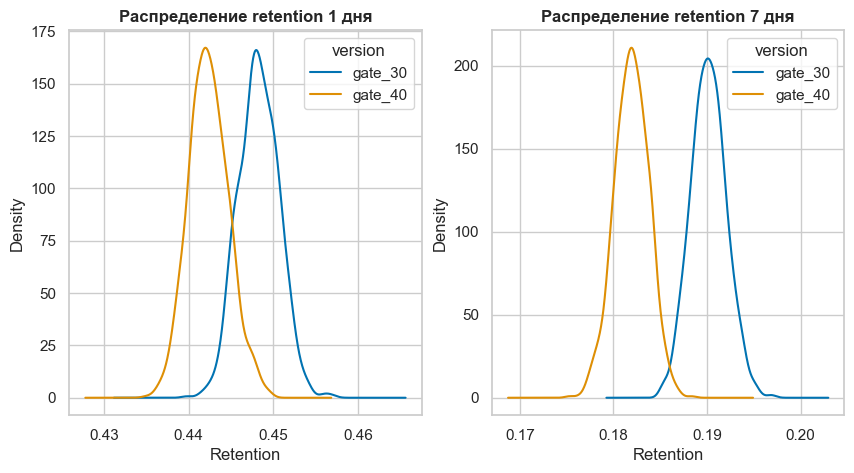

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)

r_1.plot.kde(ax=ax1)
ax1.set_xlabel("Retention")
ax1.set_title("Распределение retention 1 дня", fontweight="bold")



r_7.plot.kde(ax=ax2)
ax2.set_xlabel("Retention")
ax2.set_title("Распределение retention 7 дня", fontweight="bold")

plt.show()

In [49]:
r_1['diff'] = r_1.gate_30-r_1.gate_40
print(r_1['diff'].quantile(0.975))
print(r_1['diff'].quantile(0.025))

0.012219948948418017
-0.0004127157800360755


In [50]:
r_7['diff'] = r_7.gate_30-r_7.gate_40
print(r_7['diff'].quantile(0.975))
print(r_7['diff'].quantile(0.025))

0.013564522572816151
0.0033442672405747374


Доверительные интервалы перекрываются, что значит, что различия между двумя группами статистически незначимы, поэтому мы не отклоняем H0. Но при этом показатели в контрольной группе лучше, чем в тестовой.